In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Import data

In [2]:
df = pd.read_csv("data/daily_min_temp.csv", index_col="Date", parse_dates=["Date"])
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


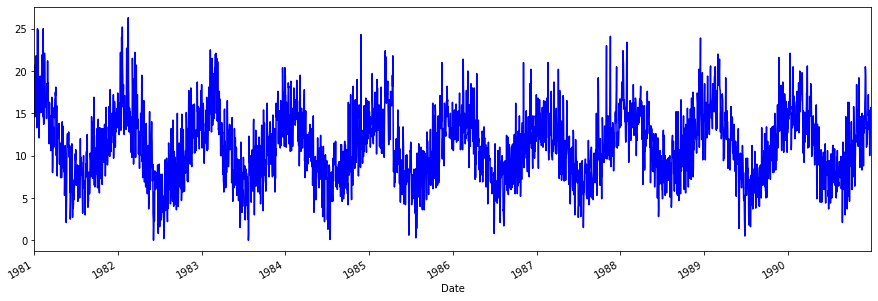

In [3]:
df.Temp.plot(figsize=(15, 5), color='b')

## Dataset Splitting

In [4]:
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape,ts_test.shape

((2920, 1), (730, 1))

## Dataset & Dataloader

In [5]:
from torch.utils.data import TensorDataset, DataLoader
from jcopdl.utils.dataloader import TimeSeriesDataset

In [6]:
bs = 32
seq_len = 14

train_set = TimeSeriesDataset(ts_train, "Temp", seq_len)
trainloader = DataLoader(train_set, batch_size=bs, num_workers=4)

test_set = TimeSeriesDataset(ts_test, "Temp", seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (208, 14, 1)
Note: last 7 data excluded

(N, S, F): (52, 14, 1)
Note: last 1 data excluded



## Arsitektur & Config

In [7]:
class GRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layer, dropout, batch_first=True):
        super().__init__()
        self.rnn = nn.GRU(input_size, hidden_size, num_layer, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden
        

In [8]:
config = set_config({
    "input_size": 1,
    "output_size": 1,
    "seq_len": 14,
    "bs": 32,
    "hidden_size": 64,
    "num_layer": 2,
    "drop_out": 0
})

## Training Preparation => MCOC

In [9]:
model = GRU(config.input_size, config.output_size, config.hidden_size, config.num_layer, config.drop_out).to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model/gru")

## Training

In [10]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost



Epoch     1
Train_cost  = 117.9694 | Test_cost  = 107.0330 | 




Epoch     2
Train_cost  = 89.4571 | Test_cost  = 80.5461 | 




Epoch     3
Train_cost  = 67.8101 | Test_cost  = 64.7153 | 




Epoch     4
Train_cost  = 55.6648 | Test_cost  = 55.4929 | 




Epoch     5
Train_cost  = 48.0423 | Test_cost  = 48.7167 | 




Epoch     6
Train_cost  = 42.2139 | Test_cost  = 43.1970 | 




Epoch     7
Train_cost  = 37.4292 | Test_cost  = 38.5617 | 




Epoch     8
Train_cost  = 33.4248 | Test_cost  = 34.6425 | 




Epoch     9
Train_cost  = 30.0682 | Test_cost  = 31.3386 | 




Epoch    10
Train_cost  = 27.2709 | Test_cost  = 28.5711 | 




Epoch    11
Train_cost  = 24.9593 | Test_cost  = 26.2707 | 




Epoch    12
Train_cost  = 23.0672 | Test_cost  = 24.3742 | 




Epoch    13
Train_cost  = 21.5342 | Test_cost  = 22.8234 | 




Epoch    14
Train_cost  = 20.3053 | Test_cost  = 21.5656 | 




Epoch    15
Train_cost  = 19.3307 | Test_cost  = 20.5538 | 




Epoch    16
Train_cost  = 18.5663 | Test_cost  = 19.7460 | 




Epoch    17
Train_cost  = 17.9736 | Test_cost  = 19.1058 | 




Epoch    18
Train_cost  = 17.5188 | Test_cost  = 18.6017 | 




Epoch    19
Train_cost  = 17.1736 | Test_cost  = 18.2069 | 




Epoch    20
Train_cost  = 16.9141 | Test_cost  = 17.8990 | 


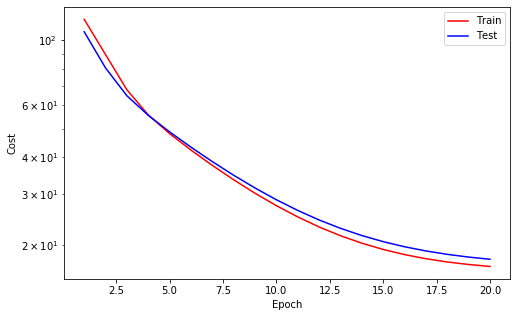



Epoch    21
Train_cost  = 16.7209 | Test_cost  = 17.6597 | 




Epoch    22
Train_cost  = 16.5780 | Test_cost  = 17.4741 | 




Epoch    23
Train_cost  = 16.4731 | Test_cost  = 17.3303 | 




Epoch    24
Train_cost  = 16.3963 | Test_cost  = 17.2187 | 




Epoch    25
Train_cost  = 16.3403 | Test_cost  = 17.1321 | 




Epoch    26
Train_cost  = 16.2992 | Test_cost  = 17.0647 | 




Epoch    27
Train_cost  = 16.2690 | Test_cost  = 17.0120 | 




Epoch    28
Train_cost  = 16.2465 | Test_cost  = 16.9707 | 




Epoch    29
Train_cost  = 16.2295 | Test_cost  = 16.9382 | 




Epoch    30
Train_cost  = 16.2162 | Test_cost  = 16.9124 | 




Epoch    31
Train_cost  = 16.2057 | Test_cost  = 16.8919 | 




Epoch    32
Train_cost  = 16.1971 | Test_cost  = 16.8753 | 




Epoch    33
Train_cost  = 16.1897 | Test_cost  = 16.8619 | 




Epoch    34
Train_cost  = 16.1831 | Test_cost  = 16.8509 | 




Epoch    35
Train_cost  = 16.1770 | Test_cost  = 16.8416 | 




Epoch    36
Train_cost  = 16.1711 | Test_cost  = 16.8337 | 




Epoch    37
Train_cost  = 16.1653 | Test_cost  = 16.8266 | 




Epoch    38
Train_cost  = 16.1593 | Test_cost  = 16.8201 | 




Epoch    39
Train_cost  = 16.1530 | Test_cost  = 16.8137 | 




Epoch    40
Train_cost  = 16.1462 | Test_cost  = 16.8073 | 


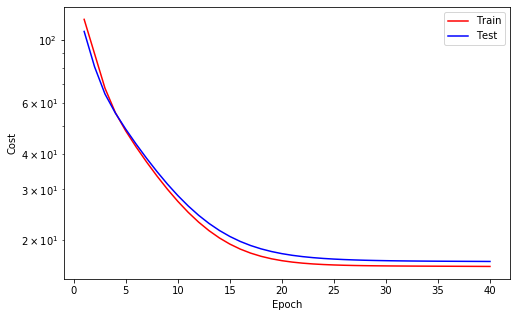



Epoch    41
Train_cost  = 16.1383 | Test_cost  = 16.8001 | 




Epoch    42
Train_cost  = 16.1288 | Test_cost  = 16.7912 | 




Epoch    43
Train_cost  = 16.1162 | Test_cost  = 16.7784 | 




Epoch    44
Train_cost  = 16.0968 | Test_cost  = 16.7553 | 




Epoch    45
Train_cost  = 16.0594 | Test_cost  = 16.7085 | 




Epoch    46
Train_cost  = 15.9872 | Test_cost  = 16.6351 | 




Epoch    47
Train_cost  = 15.8752 | Test_cost  = 16.5423 | 




Epoch    48
Train_cost  = 15.7230 | Test_cost  = 16.3212 | 




Epoch    49
Train_cost  = 15.4454 | Test_cost  = 15.9231 | 




Epoch    50
Train_cost  = 14.9704 | Test_cost  = 15.3961 | 




Epoch    51
Train_cost  = 14.4004 | Test_cost  = 14.5376 | 




Epoch    52
Train_cost  = 13.5113 | Test_cost  = 13.3148 | 




Epoch    53
Train_cost  = 12.2729 | Test_cost  = 12.2599 | 




Epoch    54
Train_cost  = 11.5330 | Test_cost  = 11.6593 | 




Epoch    55
Train_cost  = 10.9578 | Test_cost  = 10.9162 | 




Epoch    56
Train_cost  = 10.4054 | Test_cost  = 10.3410 | 




Epoch    57
Train_cost  = 9.9670 | Test_cost  = 9.8152 | 




Epoch    58
Train_cost  = 9.5755 | Test_cost  = 9.3602 | 




Epoch    59
Train_cost  = 9.2378 | Test_cost  = 8.9574 | 




Epoch    60
Train_cost  = 8.9522 | Test_cost  = 8.6130 | 


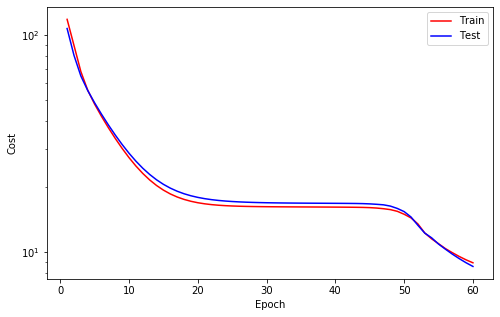



Epoch    61
Train_cost  = 8.7061 | Test_cost  = 8.3103 | 




Epoch    62
Train_cost  = 8.4868 | Test_cost  = 8.0568 | 




Epoch    63
Train_cost  = 8.3024 | Test_cost  = 7.8356 | 




Epoch    64
Train_cost  = 8.1469 | Test_cost  = 7.6327 | 




Epoch    65
Train_cost  = 8.0061 | Test_cost  = 7.4504 | 




Epoch    66
Train_cost  = 7.8756 | Test_cost  = 7.2900 | 




Epoch    67
Train_cost  = 7.7582 | Test_cost  = 7.1449 | 




Epoch    68
Train_cost  = 7.6517 | Test_cost  = 7.0126 | 




Epoch    69
Train_cost  = 7.5538 | Test_cost  = 6.8940 | 




Epoch    70
Train_cost  = 7.4648 | Test_cost  = 6.7870 | 




Epoch    71
Train_cost  = 7.3842 | Test_cost  = 6.6900 | 




Epoch    72
Train_cost  = 7.3108 | Test_cost  = 6.6023 | 




Epoch    73
Train_cost  = 7.2440 | Test_cost  = 6.5227 | 




Epoch    74
Train_cost  = 7.1832 | Test_cost  = 6.4497 | 




Epoch    75
Train_cost  = 7.1276 | Test_cost  = 6.3827 | 




Epoch    76
Train_cost  = 7.0766 | Test_cost  = 6.3209 | 




Epoch    77
Train_cost  = 7.0296 | Test_cost  = 6.2635 | 




Epoch    78
Train_cost  = 6.9861 | Test_cost  = 6.2099 | 




Epoch    79
Train_cost  = 6.9456 | Test_cost  = 6.1597 | 




Epoch    80
Train_cost  = 6.9079 | Test_cost  = 6.1125 | 


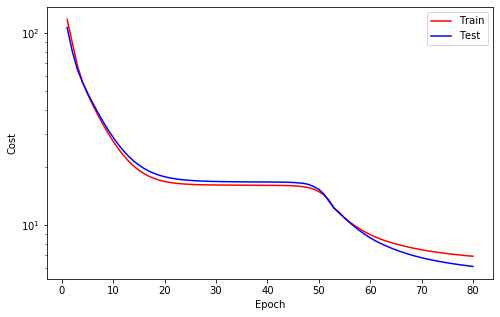



Epoch    81
Train_cost  = 6.8726 | Test_cost  = 6.0681 | 




Epoch    82
Train_cost  = 6.8393 | Test_cost  = 6.0262 | 




Epoch    83
Train_cost  = 6.8081 | Test_cost  = 5.9868 | 




Epoch    84
Train_cost  = 6.7786 | Test_cost  = 5.9496 | 




Epoch    85
Train_cost  = 6.7507 | Test_cost  = 5.9144 | 




Epoch    86
Train_cost  = 6.7244 | Test_cost  = 5.8812 | 




Epoch    87
Train_cost  = 6.6995 | Test_cost  = 5.8497 | 




Epoch    88
Train_cost  = 6.6759 | Test_cost  = 5.8199 | 




Epoch    89
Train_cost  = 6.6535 | Test_cost  = 5.7916 | 




Epoch    90
Train_cost  = 6.6322 | Test_cost  = 5.7647 | 




Epoch    91
Train_cost  = 6.6118 | Test_cost  = 5.7390 | 




Epoch    92
Train_cost  = 6.5924 | Test_cost  = 5.7146 | 




Epoch    93
Train_cost  = 6.5738 | Test_cost  = 5.6911 | 




Epoch    94
Train_cost  = 6.5560 | Test_cost  = 5.6685 | 




Epoch    95
Train_cost  = 6.5390 | Test_cost  = 5.6465 | 




Epoch    96
Train_cost  = 6.5227 | Test_cost  = 5.6252 | 




Epoch    97
Train_cost  = 6.5071 | Test_cost  = 5.6045 | 




Epoch    98
Train_cost  = 6.4922 | Test_cost  = 5.5847 | 




Epoch    99
Train_cost  = 6.4779 | Test_cost  = 5.5656 | 




Epoch   100
Train_cost  = 6.4641 | Test_cost  = 5.5471 | 


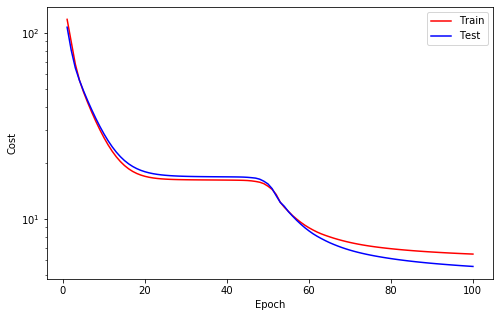



Epoch   101
Train_cost  = 6.4508 | Test_cost  = 5.5291 | 




Epoch   102
Train_cost  = 6.4380 | Test_cost  = 5.5116 | 




Epoch   103
Train_cost  = 6.4256 | Test_cost  = 5.4946 | 




Epoch   104
Train_cost  = 6.4138 | Test_cost  = 5.4782 | 




Epoch   105
Train_cost  = 6.4024 | Test_cost  = 5.4623 | 




Epoch   106
Train_cost  = 6.3914 | Test_cost  = 5.4469 | 




Epoch   107
Train_cost  = 6.3807 | Test_cost  = 5.4320 | 




Epoch   108
Train_cost  = 6.3705 | Test_cost  = 5.4175 | 




Epoch   109
Train_cost  = 6.3606 | Test_cost  = 5.4035 | 




Epoch   110
Train_cost  = 6.3510 | Test_cost  = 5.3900 | 




Epoch   111
Train_cost  = 6.3417 | Test_cost  = 5.3769 | 




Epoch   112
Train_cost  = 6.3327 | Test_cost  = 5.3642 | 




Epoch   113
Train_cost  = 6.3240 | Test_cost  = 5.3519 | 




Epoch   114
Train_cost  = 6.3156 | Test_cost  = 5.3401 | 




Epoch   115
Train_cost  = 6.3074 | Test_cost  = 5.3286 | 




Epoch   116
Train_cost  = 6.2995 | Test_cost  = 5.3175 | 




Epoch   117
Train_cost  = 6.2917 | Test_cost  = 5.3068 | 




Epoch   118
Train_cost  = 6.2841 | Test_cost  = 5.2965 | 




Epoch   119
Train_cost  = 6.2768 | Test_cost  = 5.2865 | 




Epoch   120
Train_cost  = 6.2696 | Test_cost  = 5.2769 | 


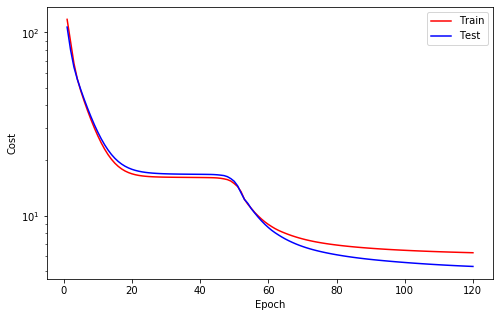



Epoch   121
Train_cost  = 6.2625 | Test_cost  = 5.2676 | 




Epoch   122
Train_cost  = 6.2557 | Test_cost  = 5.2586 | 




Epoch   123
Train_cost  = 6.2489 | Test_cost  = 5.2500 | 




Epoch   124
Train_cost  = 6.2423 | Test_cost  = 5.2417 | 




Epoch   125
Train_cost  = 6.2358 | Test_cost  = 5.2338 | 




Epoch   126
Train_cost  = 6.2294 | Test_cost  = 5.2261 | 




Epoch   127
Train_cost  = 6.2231 | Test_cost  = 5.2188 | 




Epoch   128
Train_cost  = 6.2169 | Test_cost  = 5.2118 | 




Epoch   129
Train_cost  = 6.2109 | Test_cost  = 5.2049 | 




Epoch   130
Train_cost  = 6.2049 | Test_cost  = 5.1983 | 




Epoch   131
Train_cost  = 6.1990 | Test_cost  = 5.1918 | 




Epoch   132
Train_cost  = 6.1932 | Test_cost  = 5.1854 | 




Epoch   133
Train_cost  = 6.1875 | Test_cost  = 5.1793 | 




Epoch   134
Train_cost  = 6.1819 | Test_cost  = 5.1734 | 




Epoch   135
Train_cost  = 6.1764 | Test_cost  = 5.1676 | 




Epoch   136
Train_cost  = 6.1709 | Test_cost  = 5.1621 | 




Epoch   137
Train_cost  = 6.1655 | Test_cost  = 5.1566 | 




Epoch   138
Train_cost  = 6.1601 | Test_cost  = 5.1514 | 




Epoch   139
Train_cost  = 6.1547 | Test_cost  = 5.1462 | 




Epoch   140
Train_cost  = 6.1494 | Test_cost  = 5.1412 | 


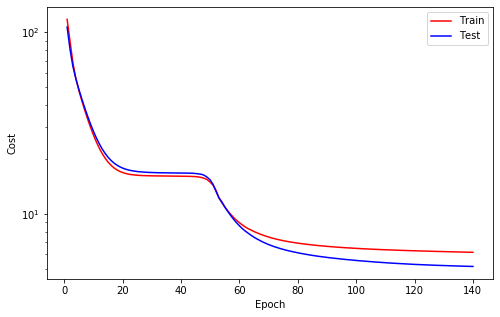



Epoch   141
Train_cost  = 6.1441 | Test_cost  = 5.1363 | 




Epoch   142
Train_cost  = 6.1388 | Test_cost  = 5.1316 | 




Epoch   143
Train_cost  = 6.1335 | Test_cost  = 5.1269 | 




Epoch   144
Train_cost  = 6.1283 | Test_cost  = 5.1223 | 




Epoch   145
Train_cost  = 6.1231 | Test_cost  = 5.1179 | 




Epoch   146
Train_cost  = 6.1180 | Test_cost  = 5.1136 | 




Epoch   147
Train_cost  = 6.1130 | Test_cost  = 5.1095 | 




Epoch   148
Train_cost  = 6.1080 | Test_cost  = 5.1055 | 




Epoch   149
Train_cost  = 6.1030 | Test_cost  = 5.1016 | 




Epoch   150
Train_cost  = 6.0980 | Test_cost  = 5.0978 | 




Epoch   151
Train_cost  = 6.0930 | Test_cost  = 5.0942 | 




Epoch   152
Train_cost  = 6.0880 | Test_cost  = 5.0906 | 




Epoch   153
Train_cost  = 6.0831 | Test_cost  = 5.0871 | 




Epoch   154
Train_cost  = 6.0782 | Test_cost  = 5.0837 | 




Epoch   155
Train_cost  = 6.0733 | Test_cost  = 5.0804 | 




Epoch   156
Train_cost  = 6.0685 | Test_cost  = 5.0772 | 




Epoch   157
Train_cost  = 6.0637 | Test_cost  = 5.0740 | 




Epoch   158
Train_cost  = 6.0589 | Test_cost  = 5.0710 | 




Epoch   159
Train_cost  = 6.0542 | Test_cost  = 5.0680 | 




Epoch   160
Train_cost  = 6.0495 | Test_cost  = 5.0652 | 


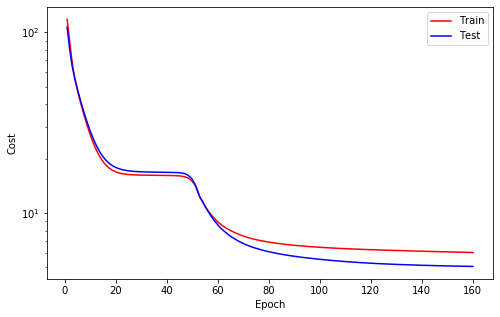



Epoch   161
Train_cost  = 6.0448 | Test_cost  = 5.0624 | 




Epoch   162
Train_cost  = 6.0402 | Test_cost  = 5.0597 | 




Epoch   163
Train_cost  = 6.0356 | Test_cost  = 5.0571 | 




Epoch   164
Train_cost  = 6.0310 | Test_cost  = 5.0547 | 




Epoch   165
Train_cost  = 6.0265 | Test_cost  = 5.0523 | 




Epoch   166
Train_cost  = 6.0221 | Test_cost  = 5.0500 | 




Epoch   167
Train_cost  = 6.0176 | Test_cost  = 5.0478 | 




Epoch   168
Train_cost  = 6.0132 | Test_cost  = 5.0457 | 




Epoch   169
Train_cost  = 6.0089 | Test_cost  = 5.0437 | 




Epoch   170
Train_cost  = 6.0046 | Test_cost  = 5.0418 | 




Epoch   171
Train_cost  = 6.0003 | Test_cost  = 5.0400 | 




Epoch   172
Train_cost  = 5.9960 | Test_cost  = 5.0384 | 




Epoch   173
Train_cost  = 5.9918 | Test_cost  = 5.0368 | 




Epoch   174
Train_cost  = 5.9876 | Test_cost  = 5.0353 | 




Epoch   175
Train_cost  = 5.9835 | Test_cost  = 5.0339 | 




Epoch   176
Train_cost  = 5.9793 | Test_cost  = 5.0327 | 




Epoch   177
Train_cost  = 5.9752 | Test_cost  = 5.0315 | 




Epoch   178
Train_cost  = 5.9711 | Test_cost  = 5.0304 | 




Epoch   179
Train_cost  = 5.9670 | Test_cost  = 5.0294 | 




Epoch   180
Train_cost  = 5.9629 | Test_cost  = 5.0285 | 


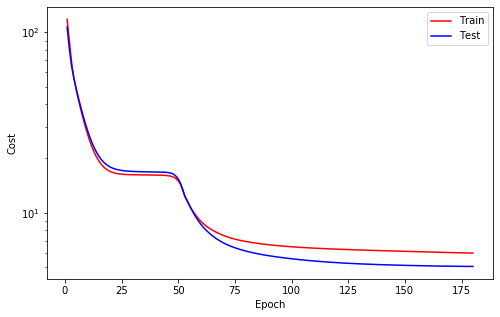



Epoch   181
Train_cost  = 5.9588 | Test_cost  = 5.0277 | 




Epoch   182
Train_cost  = 5.9548 | Test_cost  = 5.0270 | 




Epoch   183
Train_cost  = 5.9507 | Test_cost  = 5.0264 | 




Epoch   184
Train_cost  = 5.9466 | Test_cost  = 5.0259 | 




Epoch   185
Train_cost  = 5.9426 | Test_cost  = 5.0255 | 




Epoch   186
Train_cost  = 5.9385 | Test_cost  = 5.0251 | 




Epoch   187
Train_cost  = 5.9344 | Test_cost  = 5.0248 | 




Epoch   188
Train_cost  = 5.9303 | Test_cost  = 5.0247 | 




Epoch   189
Train_cost  = 5.9261 | Test_cost  = 5.0246 | 




Epoch   190
Train_cost  = 5.9220 | Test_cost  = 5.0246 | 




Epoch   191
Train_cost  = 5.9178 | Test_cost  = 5.0246 | 
==> EarlyStop patience =  1 | Best test_cost: 5.0246




Epoch   192
Train_cost  = 5.9136 | Test_cost  = 5.0248 | 
==> EarlyStop patience =  2 | Best test_cost: 5.0246




Epoch   193
Train_cost  = 5.9094 | Test_cost  = 5.0250 | 
==> EarlyStop patience =  3 | Best test_cost: 5.0246




Epoch   194
Train_cost  = 5.9051 | Test_cost  = 5.0254 | 
==> EarlyStop patience =  4 | Best test_cost: 5.0246




Epoch   195
Train_cost  = 5.9008 | Test_cost  = 5.0258 | 
==> EarlyStop patience =  5 | Best test_cost: 5.0246
==> Execute Early Stopping at epoch: 195 | Best test_cost: 5.0246
==> Best model is saved at model/gru


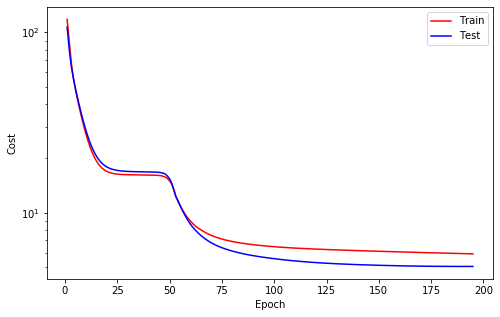

In [11]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

## Sanity Check

In [12]:
from luwiji.rnn import illustration

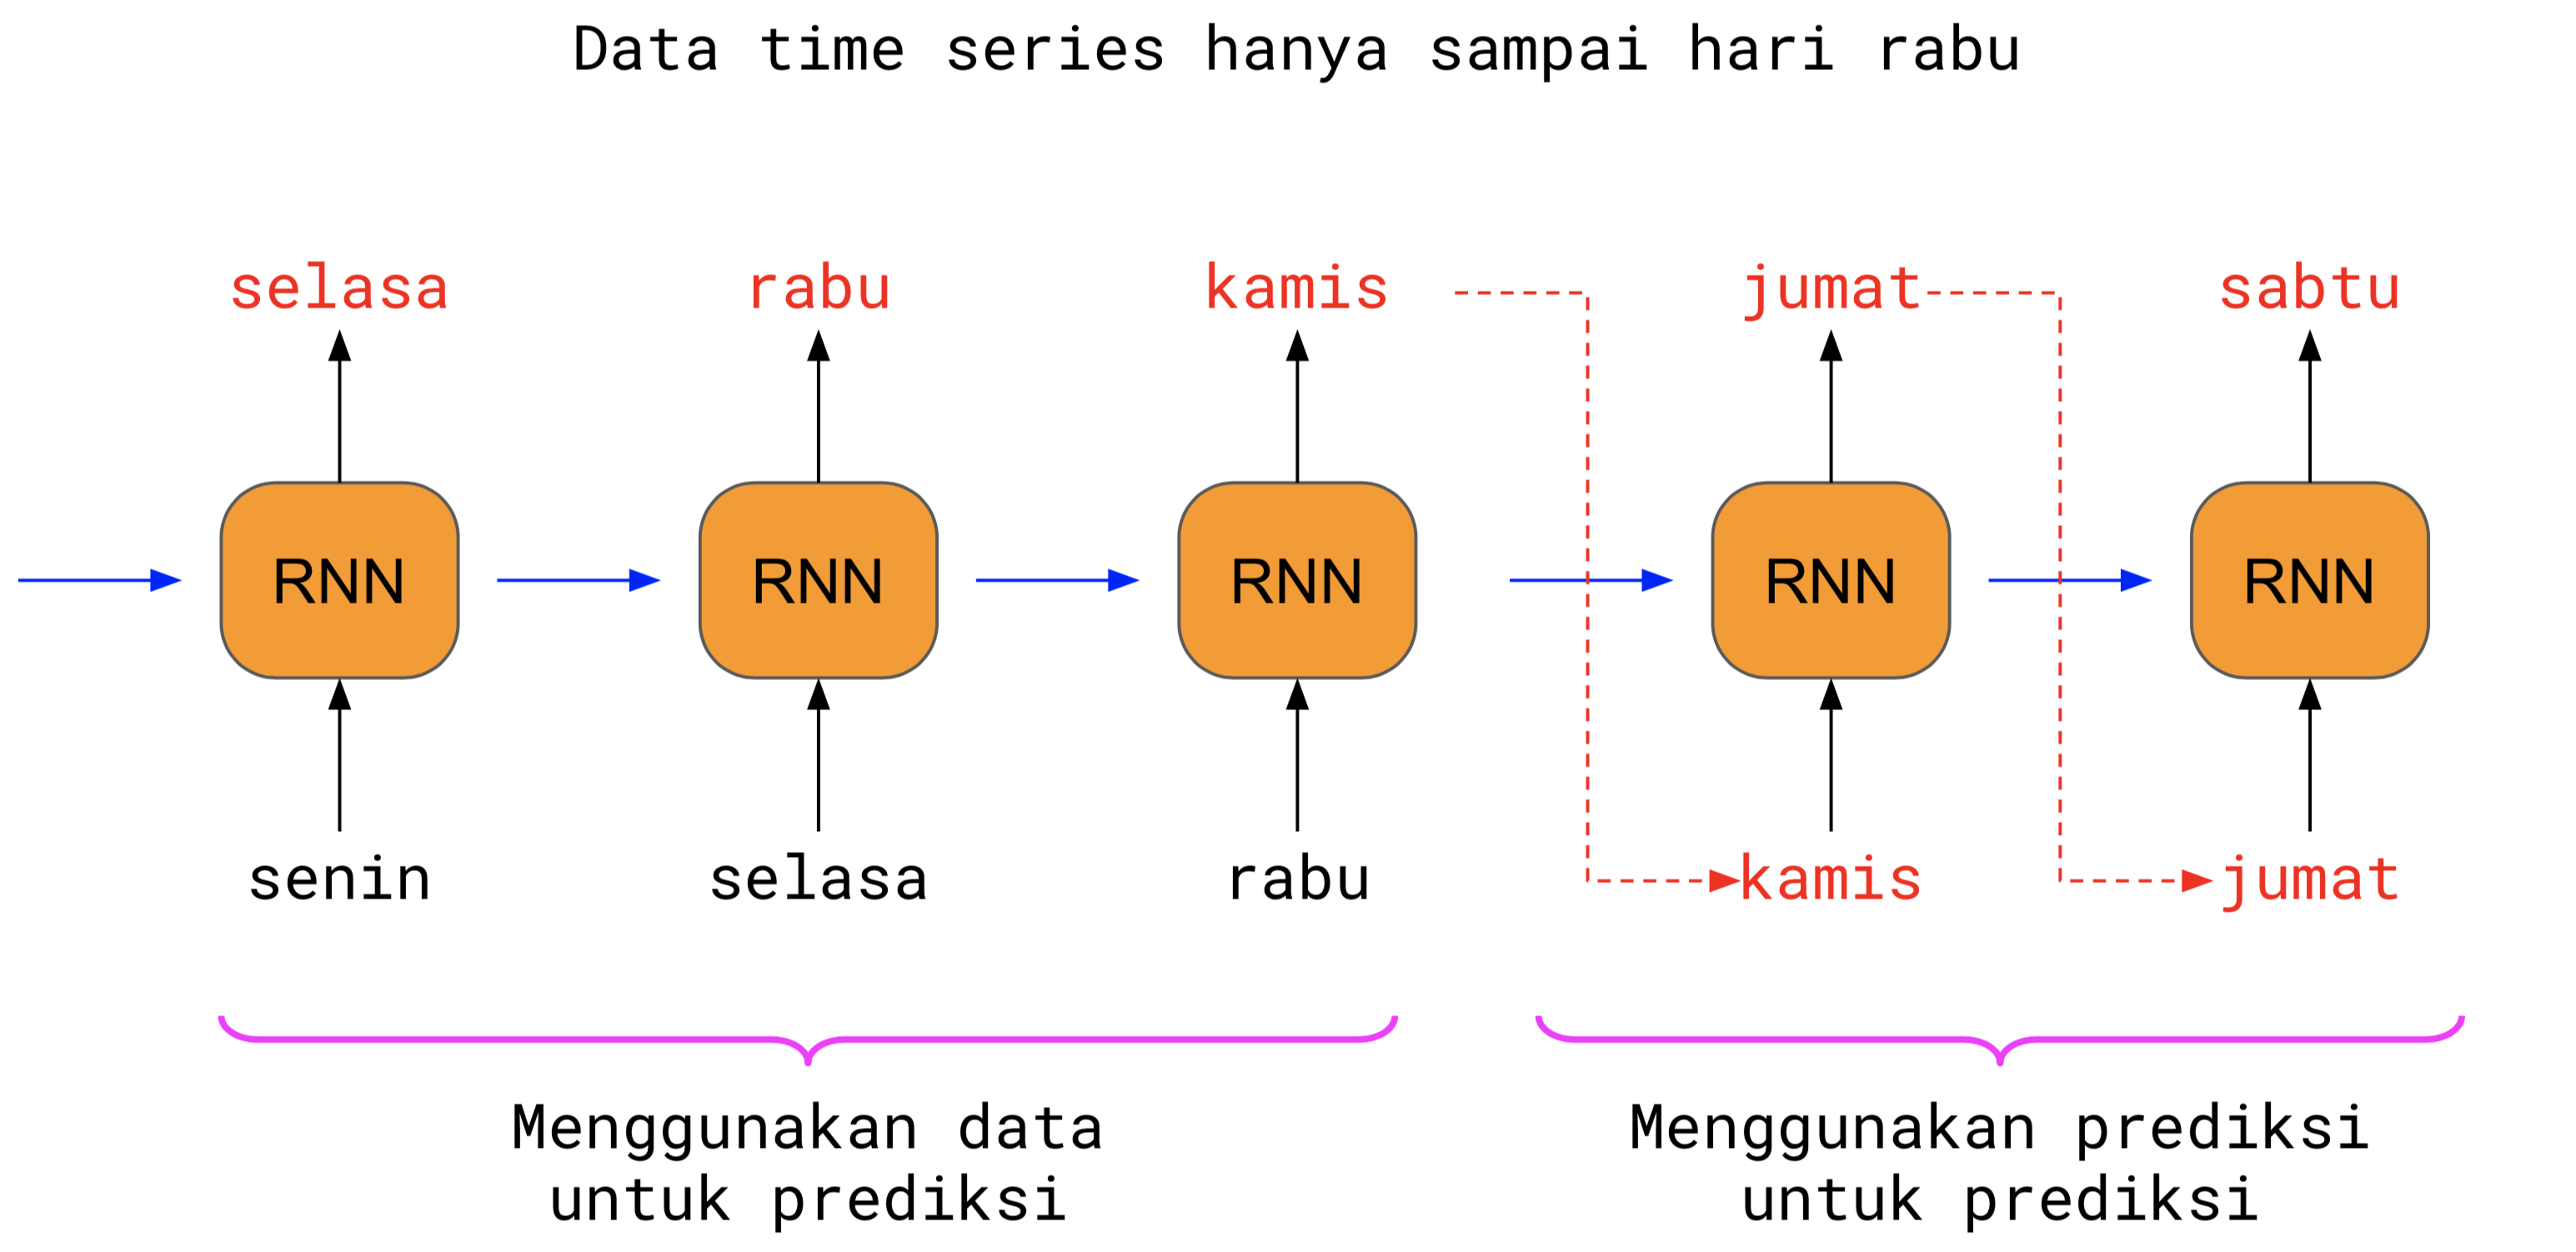

In [13]:
illustration.forecast

In [14]:
from utils import data4pred, pred4pred

In [15]:
train_forecast_set = TimeSeriesDataset(ts_train, "Temp", 1)
trainforecastloader = DataLoader(train_forecast_set)

test_forecast_set = TimeSeriesDataset(ts_test, "Temp", 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (2919, 1, 1)
Note: last 0 data excluded

(N, S, F): (729, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

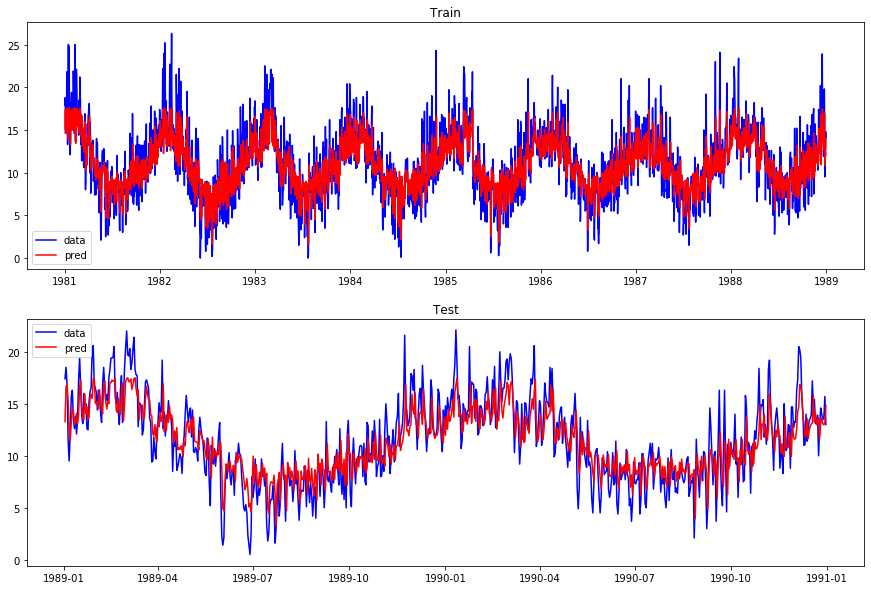

In [16]:
# Data for Pred
plt.figure(figsize=(15, 10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")

Text(0.5, 1.0, 'Test')

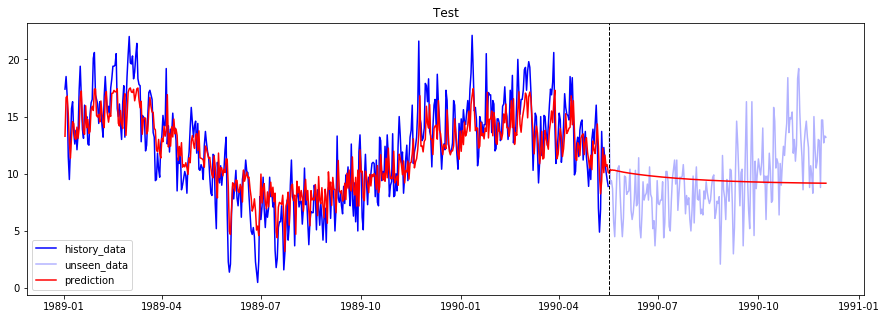

In [17]:
# Pred for Pred
plt.figure(figsize=(15, 5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")